In [1]:
import cv2
import sys
import face_recognition
import numpy as np
import time
from collections import deque
import imutils
from matplotlib import pyplot as plt
import os
from array2gif import write_gif
from sklearn.cluster import MiniBatchKMeans
import telebot
from telebot import types
from telebot import apihelper


(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')

In [2]:
# telegram bot settings
gif = deque(maxlen=50)
stop_frame = 20
count_frame = 0

bot = telebot.TeleBot('your key')
#https://hidemy.name/ru/proxy-list/?type=5#list
ip = '45.80.70.45' 
port = '1080'
apihelper.proxy = {'https': 'socks5://{}:{}'.format(ip,port)}


# send video through telegram bot
def send_gif(gif):
    fin_gif = []
    it = 0
    for ff in gif:
        # load the image and grab its width and height
        #image = cv2.imread("/Users/V/Desktop/Screenshot 2020-04-17 at 18.02.54.png")
        image = imutils.resize(ff, width=240)
        (h, w) = image.shape[:2]
        # convert the image from the RGB color space to the L*a*b*
        # color space -- since we will be clustering using k-means
        # which is based on the euclidean distance, we'll use the
        # L*a*b* color space where the euclidean distance implies
        # perceptual meaning
        image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        # reshape the image into a feature vector so that k-means
        # can be applied
        image = image.reshape((image.shape[0] * image.shape[1], 3))
        # apply k-means using the specified number of clusters and
        # then create the quantized image based on the predictions
        if it == 0 :
            clt = MiniBatchKMeans(n_clusters = 5)
        it+=1

        labels = clt.fit_predict(image)
        quant = clt.cluster_centers_.astype("uint8")[labels]
        # reshape the feature vectors to images
        quant = quant.reshape((h, w, 3))
        image = image.reshape((h, w, 3))
        # convert from L*a*b* to RGB
        quant = cv2.cvtColor(quant, cv2.COLOR_LAB2BGR)
        image = cv2.cvtColor(image, cv2.COLOR_LAB2BGR)
        # display the images and wait for a keypress
        #cv2.imshow("image", np.hstack([image, quant]))
        #cv2.waitKey(0)
        fin_gif.append(np.transpose(quant,(1, 0, 2))[:, :, ::-1])
    
    write_gif(fin_gif, 'DS_demo.gif', fps=5)
    
    #https://github.com/eternnoir/pyTelegramBotAPI
    doc = open('DS_demo.gif', 'rb')
    bot.send_document(67257831, doc)

In [3]:
#doc = open('DS_demo.gif', 'rb')
#bot.send_document(67257831, doc)

In [4]:
# video input
VIDEO_PATH = '/Users/V/Desktop/p/me1inout720.mp4'
video = cv2.VideoCapture(VIDEO_PATH)
# exit if video not opened
if not video.isOpened():
    print ("Could not open video")
    sys.exit() 
# read first frame
ok, frame = video.read()
if not ok:
    print ('Cannot read video file')
    sys.exit()

In [5]:
# yolo settings
# load the COCO class labels our YOLO model was trained on
YOLO_PATH ='/Users/V/Desktop/P/codes/yolo-object-detection/yolo-coco'
# minimum probability to filter weak detections
YOLO_CONF = 0.25
# threshold when applying non-maxima suppression
YOLO_TRES = 0.3

labelsPath = os.path.sep.join([YOLO_PATH, "coco.names"])
LABELS = open(labelsPath).read().strip().split("\n")
# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),dtype="uint8")
# derive the paths to the YOLO weights and model configuration
weightsPath = os.path.sep.join([YOLO_PATH, "yolov3.weights"])
configPath = os.path.sep.join([YOLO_PATH, "yolov3.cfg"])
# load our YOLO object detector trained on COCO dataset (80 classes)
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

[INFO] loading YOLO from disk...


In [6]:
# load our input image and grab its spatial dimensions
needed_objects = ['person','snowboard','skis','laptop','tvmonitor']
def yolo_detect(frame):
    image = frame.copy()
    # image = cv2.imread(args["image"])
    (H, W) = image.shape[:2]
    # determine only the *output* layer names that we need from YOLO
    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    # construct a blob from the input image and then perform a forward
    # pass of the YOLO object detector, giving us our bounding boxes and
    # associated probabilities
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),
        swapRB=True, crop=False)
    net.setInput(blob)
    start = time.time()
    layerOutputs = net.forward(ln)
    end = time.time()
    # show timing information on YOLO
    print("[INFO] YOLO took {:.6f} seconds".format(end - start))
    
    # initialize our lists of detected bounding boxes, confidences, and
    # class IDs, respectively
    boxes = []
    confidences = []
    classIDs = []
    PC = False
    PERSON = False
    
    # loop over each of the layer outputs
    for output in layerOutputs:
        # loop over each of the detections
        for detection in output:
            # extract the class ID and confidence (i.e., probability) of
            # the current object detection
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            # filter out weak predictions by ensuring the detected
            # probability is greater than the minimum probability
            
            if confidence > YOLO_CONF and LABELS[classID] in needed_objects:
                # scale the bounding box coordinates back relative to the
                # size of the image, keeping in mind that YOLO actually
                # returns the center (x, y)-coordinates of the bounding
                # box followed by the boxes' width and height
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")
                # use the center (x, y)-coordinates to derive the top and
                # and left corner of the bounding box
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                # update our list of bounding box coordinates, confidences,
                # and class IDs
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)
                
    # apply non-maxima suppression to suppress weak, overlapping bounding
    # boxes
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, YOLO_CONF, YOLO_TRES)
    
    # ensure at least one detection exists
    if len(idxs) > 0:
        # loop over the indexes we are keeping
        for i in idxs.flatten():
            # extract the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            # draw a bounding box rectangle and label on the image
            color = [int(c) for c in COLORS[classIDs[i]]]
            print(LABELS[classIDs[i]],x,y)
            if LABELS[classIDs[i]] in needed_objects[0]:
                PERSON = True
                person_c = (x,y,w,h)
            if LABELS[classIDs[i]] in needed_objects[-2:]:
                if x <850 and x>800:
                    PC = True
                    cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
                    text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
                    cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,0.5, color, 2)
            else:
                cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
                text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
                cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,0.5, color, 2)
    return image,PC,PERSON,person_c

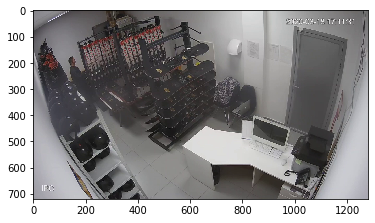

In [7]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
# show first frame
plt.show()

[INFO] YOLO took 1.050853 seconds
tvmonitor 821 397
tvmonitor 994 439
person 130 178


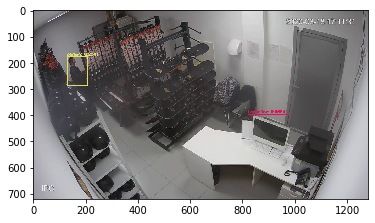

(True, True)

In [8]:
# test Yolo
frame_y,PC,PERSON,cc=yolo_detect(frame)
cv2.imwrite('/Users/V/Desktop/frame_y.jpg',frame_y)
# opencv library uses bgr color scheme
plt.imshow(cv2.cvtColor(frame_y, cv2.COLOR_BGR2RGB))
# show first frame
plt.show()
PC,PERSON

In [9]:
# set up tracker
# tracker_types = ['BOOSTING', 'MIL','KCF', 'TLD', 'MEDIANFLOW', 'GOTURN', 'MOSSE', 'CSRT']
tracker_type = 'KCF'

if int(minor_ver) < 3:
    tracker = cv2.Tracker_create(tracker_type)
else:
    tracker = cv2.TrackerKCF_create()

door_opened=False

# Define an initial bounding box
#bbox = (1485, 88, 91, 88)
#bbox = (733, 44, 52, 36)
bbox = (1004, 62, 32, 33)

# Uncomment the line below to select a different bounding box
#bbox = cv2.selectROI(frame, False)
#print(bbox)

# Initialize tracker with first frame and bounding box
ok = tracker.init(frame, bbox)
bbox0=bbox
cdoor=0
p1 = (int(bbox[0]), int(bbox[1]))
p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))


In [10]:
#(712, 105, 455, 255) face region
# face recognition settings
manager_inside = False

vadim = face_recognition.load_image_file("/Users/V/Desktop/P/Vadim Palenov.JPG")
vadim_face_encoding = face_recognition.face_encodings(vadim)[0]
known_face_encodings = [
    vadim_face_encoding
]
known_face_names = [
    "Vadim"
]
start_detection = False
# Initialize some variables
face_locations = []
face_encodings = []
face_names = []

nnn=0

In [11]:
# detect face only about the door region
crop = (750, 150, 400, 150)
# track only region to understand is the manager came in or came out
track = (609, 107, 594, 354)
# 
door = (900, 100, 300, 400)

In [12]:
start_tracking = False
# to store manager track path
pts = deque(maxlen=50)
prev_pts = None

In [13]:
#set up video output
frame_width = int(video.get(3))
frame_height = int(video.get(4))
print (frame_width,frame_height)
wr = cv2.VideoWriter('/Users/V/Desktop/P/final_demo.mov',cv2.VideoWriter_fourcc('m','p','4','v'),60,
                     (frame_width,frame_height))

1280 720


In [14]:
alert = False
checked = False
sended = False
# when alert - process every
yolo_this_frame = 1
process_this_frame = 0
time.sleep(2.0)

In [15]:
while True:
    # Read a new frame
    ok, frame = video.read()
    if not ok:
        break
        
        
    # Only process every n-th frame of video to save time
    # door status tracking --------------------------------------------------------------------------------------
    if process_this_frame%3==0:
        # Update tracker
        ok, bbox = tracker.update(frame)
        if ok:
            cdoor=0
        else :
        # Tracking failure
            cdoor+=1
            # wait 5 frame to be sure door status was changed
            if cdoor>=5:
                start_detection = True
                # invert door status
                door_opened = not door_opened
                # for yolo if we already checked once process only every 50+th frame
                checked = False
                yolo_this_frame = 1
                tracker.clear()
                tracker = cv2.TrackerKCF_create()
                ok = tracker.init(frame, bbox0)
        
    
    # face detection --------------------------------------------------------------------------------------
    if process_this_frame%5==0 and start_detection and door_opened:
        small_frame = frame[crop[1]:crop[1]+crop[3], crop[0]:crop[0]+crop[2]]
        
        # Convert the image from BGR color (which OpenCV uses) to RGB color (which face_recognition uses)
        rgb_small_frame = small_frame[:, :, ::-1]
        face_locations = face_recognition.face_locations(rgb_small_frame)
        print(face_locations)
        
        face_encodings = face_recognition.face_encodings(rgb_small_frame, face_locations)

        face_names = []
        for face_encoding in face_encodings:
            # See if the face is a match for the known face(s)
            matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
            name = "Unknown"

            # # If a match was found in known_face_encodings, just use the first one.
            # if True in matches:
            #     first_match_index = matches.index(True)
            #     name = known_face_names[first_match_index]

            # Or instead, use the known face with the smallest distance to the new face
            face_distances = face_recognition.face_distance(known_face_encodings, face_encoding)
            best_match_index = np.argmin(face_distances)
            if matches[best_match_index]:
                name = known_face_names[best_match_index]

            face_names.append(name)
            
            #if name in known_face_names and not start_tracking:
             #   start_tracking=True
              #  start_detection=False
               # #manager_color = 
               # greenLower = (10, 100, 100)
                #greenUpper = (30, 255, 255)
    else:
        if process_this_frame%50==0:
            face_names = []
    
    
    # manager status --------------------------------------------------------------------------------------
    if len(set(face_names).intersection(known_face_names))>0 and not start_tracking:
        nnn+=1
        if nnn>1:
            start_tracking=True
            start_detection=False
            #manager_color = 
            greenLower = (10, 100, 100)
            greenUpper = (30, 255, 255)
    else:
        nnn=0
    manager_status = "Manager detected" if start_tracking else "No manager"
    
    
    # track the manager --------------------------------------------------------------------------------------
    if process_this_frame%1==0 and start_tracking:
        small_frame = frame[track[1]:track[1]+track[3], track[0]:track[0]+track[2]]
        
        #frame = imutils.resize(frame, width=600)
        blurred = cv2.GaussianBlur(small_frame, (11, 11), 0)
        hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)
        
        mask = cv2.inRange(hsv, greenLower, greenUpper)
        mask = cv2.erode(mask, None, iterations=2)
        mask = cv2.dilate(mask, None, iterations=2)
        
        cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
                            cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        center = None
        
        if len(cnts) > 0:
            # find the largest contour in the mask, then use
            # it to compute the minimum enclosing circle and
            # centroid
            c = max(cnts, key=cv2.contourArea)
            ((x, y), radius) = cv2.minEnclosingCircle(c)
            M = cv2.moments(c)
            #weighted center (different from x,y)
            
            # only proceed if the radius meets a minimum size
            if radius > 30:
                center = (int(M["m10"] / M["m00"])+track[0], int(M["m01"] / M["m00"])+track[1])
                # draw the circle and centroid on the frame,
                # then update the list of tracked points
                # BGR color
                cv2.circle(frame, (int(x)+track[0], int(y)+track[1]), int(radius),(0, 255, 255), 2)
                cv2.circle(frame, center, 5, (0, 0, 255), -1)
        # update the points queue
        pts.appendleft(center)
        
        # if mamager tracker queue is empty
        if prev_pts is not None and len(set(pts))==1:
            if door[0]<=prev_pts[0]<=door[0]+door[2] and door[1]<=prev_pts[1]<=door[1]+door[3]:
                print ("manager came out")
                print (prev_pts)
                start_tracking=False
                start_detection=True
        prev_pts=pts[-1]
        
        # loop over the set of tracked points
        for i in range(1, len(pts)):
            # if either of the tracked points are None, ignore
            # them
            if pts[i - 1] is None or pts[i] is None:
                continue
            # otherwise, compute the thickness of the line and
            # draw the connecting lines
            thickness = int(np.sqrt(64 / float(i + 1)) * 2.5)
            cv2.line(frame, pts[i - 1], pts[i], (0, 0, 255), thickness)
    
    
    # detect other person and PC -------------------------------------------------------------------------------
    if not start_tracking and process_this_frame>200 and (door_opened or not checked) and (process_this_frame%50==0 or yolo_this_frame):
        new_frame,PC,PERSON,cc = yolo_detect(frame)
        yolo_this_frame = 0
        checked = True
        if PC and not PERSON:
            alert = False
        else:
            alert = True
         
        
    # create gif frames -------------------------------------------------------------------------------
    if stop_frame == count_frame and not sended:
        count_frame=0
        sended = True
        send_gif(gif)
        gif = deque(maxlen=50)
        print('sended')
    else:
        gif.appendleft(frame)
    if alert:
        cv2.rectangle(frame, (cc[0], cc[1]), (cc[0] + cc[2], cc[1] + cc[3]), (0,0,255), 2)
        count_frame+=1
    else:
        sended = False
        
    
    # print results --------------------------------------------------------------------------------------
    door_status = "Door opened" if door_opened else "Door closed"
    alert_status = "ALERT. log .gif was sended" if alert else "OK"
    door_col = (0,0,255) if door_opened else (0,255,0)
    man_col = (0,255,0) if start_tracking else (0,0,255)
    alert_col = (0,0,255) if alert else (0,255,0)
    
    # face
    for (top, right, bottom, left), name in zip(face_locations, face_names):
        # Scale back up face locations since the frame we detected in was scaled to 1/4 size
        top += crop[1]
        right += crop[0]
        bottom += crop[1]
        left += crop[0]
        
        #print(left,top,bottom,right)

        # Draw a box around the face
        cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 2)

        # Draw a label with a name below the face
        cv2.rectangle(frame, (left, bottom), (right, bottom+10), (0, 0, 255), cv2.FILLED)
        font = cv2.FONT_HERSHEY_DUPLEX
        cv2.putText(frame, name, (left + 6, bottom+6), font, 0.25, (255, 255, 255), 1)
        
        
    # manager status
    cv2.putText(frame, manager_status, (100,50), cv2.FONT_HERSHEY_SIMPLEX, 0.75,man_col,2)
    
    
    # door tracker
    process_this_frame+=1
    # Draw bounding box
    cv2.rectangle(frame, p1, p2, door_col, 2, 1)
    # Display tracker type on frame
    #cv2.putText(frame, tracker_type + " Tracker", (100,20), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (50,170,50),2)
    cv2.putText(frame, door_status, (100,80), cv2.FONT_HERSHEY_SIMPLEX, 0.75,door_col,2)

    #alert status
    cv2.putText(frame, alert_status, (100,110), cv2.FONT_HERSHEY_SIMPLEX, 0.75,alert_col,2)
    
    # Display result
    #cv2.imshow("Processing video", frame)
    # Write the frame into the file 'output.avi'
    wr.write(frame)

    # Exit if ESC pressed
    k = cv2.waitKey(1) & 0xff
    if k == 27 : break

[]
[]
[]
[(14, 265, 50, 229)]
manager came out
(901, 348)
[INFO] YOLO took 0.849893 seconds
tvmonitor 822 396
person 121 180
tvmonitor 996 440
person 132 198
[]
[]
[INFO] YOLO took 0.912393 seconds
tvmonitor 822 397
person 121 181
tvmonitor 996 440
person 133 199
[INFO] YOLO took 0.829975 seconds
tvmonitor 822 396
person 122 180
tvmonitor 996 441
person 133 197
sended


In [16]:
# When everything is done, release the capture
wr.release()
video.release()
cv2.destroyAllWindows()

In [17]:
# create gif video